## 02. Github with sparse type
This notebook shows runtime figures contrasting new, perfect sparse dict tyoe

In [1]:
import pandas as pd
import json
import zipfile

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')

In [2]:
experimental_zip_path = '../results-Jul-2nd-dict.zip'

In [3]:
def load_cc_baselines(zf):
    df_cc = pd.DataFrame()
    # the C++ baseline are directly stored as csv
    for path in filter(lambda name: name.endswith('.csv'), zf.namelist()):
    
        if path == 'tuplex-c++-results.csv':
            continue
        print(f'loading {path}')
        df_cc = pd.concat((df_cc, pd.read_csv(zf.open(path))))
    df_cc = df_cc[df_cc['mode'] != 'mode']
    for name in ['time_in_s', 'loading_time_in_s', 'total_time_in_s']:
        df_cc[name] = df_cc[name].astype(float)
    for name in ['input_row_count', 'output_row_count']:
        df_cc[name] = df_cc[name].astype(int)
    return df_cc

def load_tuplex_cc(zf):
    df = pd.read_csv(zf.open('tuplex-c++-results.csv'))
    
    df = df.reset_index()[['index', 'mode', 'output_path', 'total_time_in_s', 'input_row_count', 'output_row_count']].rename(columns={'index':'mode', 'mode':'input_path', 'output_path':'time_in_s'})
    df['input_path'] = df['input_path'].apply(lambda x: x[:x.rfind(':')])
    df = df[df['mode'] != 'mode']
    df['loading_time_in_s'] = 0
    for name in ['time_in_s', 'loading_time_in_s', 'total_time_in_s']:
        df[name] = df[name].astype(float)
    for name in ['input_row_count', 'output_row_count']:
        df[name] = df[name].astype(int)
    return df

def preprocess_python_df(df_tplx):
    df = df_tplx.copy()
    #df = df.dropna()
    df.drop(columns='input_path', inplace=True)
    columns_to_keep = ['run', 'benchmark', 'input_path',
                           'total_time_in_s', 'mode', 'output_path', 'startup_time_in_s']
    df = df.explode('per_file_stats')
    df.reset_index(drop=True, inplace=True)
    
    def expand_helper(t):
        if pd.isna(t) or t is None:
            return pd.Series()
        data = {'input_row_count': t['num_input_rows'],
                'output_row_count': t['num_output_rows'],
                'time_in_s': t['duration'],
                'input_path': t['input_path']
               }
        
        return pd.Series(list(data.values()), index=(data.keys()))
    df = pd.merge(df, df['per_file_stats'].apply(expand_helper), left_index=True, right_index=True)
    
    df['mode'] = 'python'
    df['loading_time_in_s'] = np.nan
    df['total_time_in_s'] = df['job_time_in_s']
    cols = ['mode', 'input_path', 'output_path', 'time_in_s', 'loading_time_in_s',
       'total_time_in_s', 'input_row_count', 'output_row_count']
    return df[cols]

def load_python(zf):
    df = pd.read_json(zf.open('results.ndjson'), lines=True)
    return preprocess_python_df(df)

with zipfile.ZipFile(experimental_zip_path, 'r') as zf:
    print(zf.namelist())
    
    df_cc = load_cc_baselines(zf)
    
    df_tuplex_cc = load_tuplex_cc(zf)
    
    df_python = load_python(zf)
    
    

['yyjson_results.csv', 'cstruct_results.csv', 'cjson_results.csv', 'tuplex-c++-results.csv', 'results.ndjson', 'best_results.csv']
loading yyjson_results.csv
loading cstruct_results.csv
loading cjson_results.csv
loading best_results.csv


In [4]:
df_cc['mode'].unique(), df_tuplex_cc['mode'].unique(), df_python['mode'].unique()

(array(['yyjson', 'cstruct', 'cjson', 'best'], dtype=object),
 array(['tuplex-c++-sparse'], dtype=object),
 array(['python'], dtype=object))

In [5]:
df = pd.concat((df_cc, df_python, df_tuplex_cc))

In [6]:
def plot_total_time(df, normalize_to_best=False):
    df = df.copy()
    from matplotlib.ticker import FuncFormatter
    plt.figure(figsize=(10,5))
    
    if normalize_to_best:
        best_mean = df[df['mode'] == 'best']['total_time_in_s'].mean()
        df['total_time_in_s'] = df['total_time_in_s'] / best_mean
    
    sns.barplot(data=df.sort_values(by='total_time_in_s'), x='mode', y='total_time_in_s', capsize=.2)
    plt.xticks(rotation=90)
    
    if not normalize_to_best:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}s'))
        plt.ylabel('total time')
    else:
        plt.axhline(1, lw=2, linestyle='--', color='k')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}x'))
        plt.ylabel('total time relative to best C++ baseline')

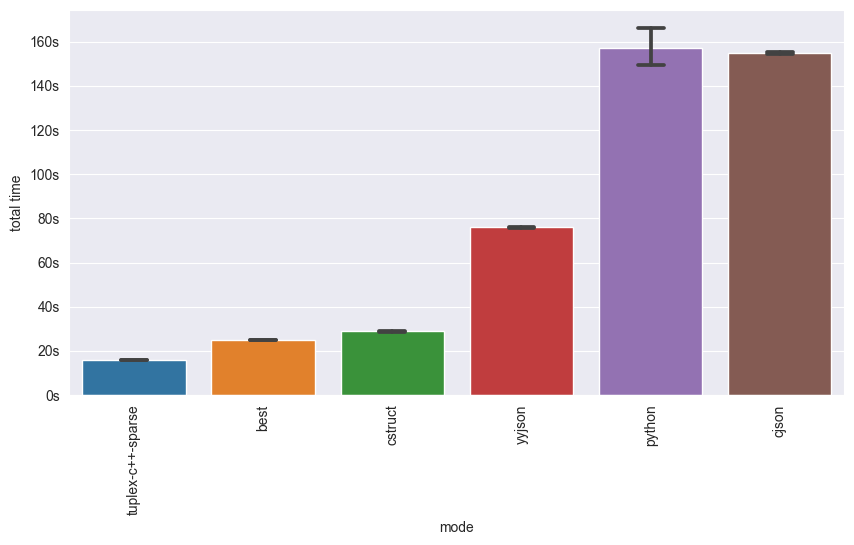

In [7]:
plot_total_time(df)

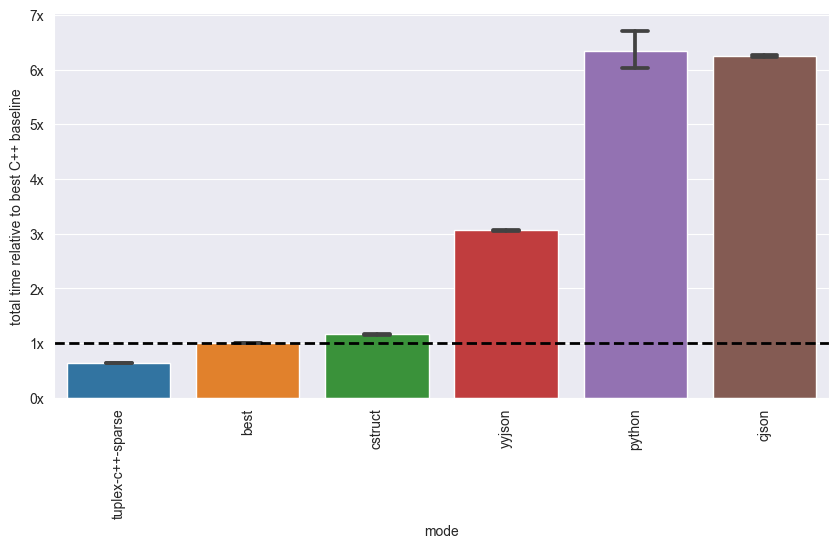

In [8]:
plot_total_time(df, True)

In [9]:
df[df['mode'] == 'tuplex-c++-sparse']['total_time_in_s'].mean()

15.673161666666664

In [10]:
df[df['mode'] == 'python']['total_time_in_s'].mean()

157.30609488487244